<a href="https://colab.research.google.com/github/veeramika/accelerate-ecommerce/blob/master/Add_new_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U fastai


     |████████████████████████████████| 194kB 19.9MB/s 
     |████████████████████████████████| 776.8MB 20kB/s 
     |████████████████████████████████| 12.8MB 240kB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files


In [ ]:
# path = untar_data(URLs.PETS)
files = get_image_files("/content/gdrive/My Drive/final/")
files[0]


Path('/content/gdrive/My Drive/final/trapeze_338.jpg')

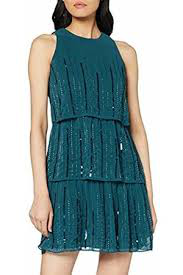

In [ ]:
import PIL
img = PIL.Image.open(files[0])
img

In [ ]:
import torch
import numpy as np

In [ ]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0


In [ ]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [ ]:
import re

In [ ]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

label_func(files[0])

'trapeze'

In [ ]:
labels = list(set(files.map(label_func)))
len(labels)

5

In [ ]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}


In [ ]:
import random

In [ ]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [ ]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [ ]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [ ]:
from fastai.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds)


In [ ]:
b = dls.one_batch()


In [ ]:
dls = dls.cuda()


In [ ]:
from fastai.vision.all import *


In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [ ]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [ ]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

Path('/content/gdrive/My Drive/final/trapeze_339.jpg')

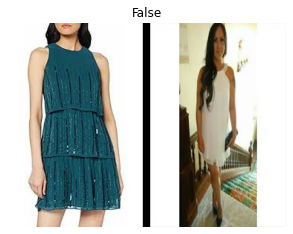

In [ ]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();
files[1]

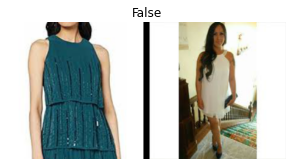

In [ ]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [ ]:
tls = TfmdLists(files, tfm, splits=splits)


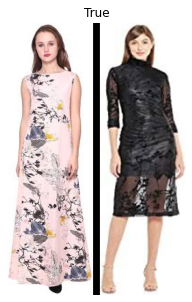

In [ ]:
show_at(tls.valid, 0)


In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
b = dls.one_batch()
type(b)


__main__.SiameseImage

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [ ]:
b = dls.one_batch()


In [ ]:
dls._types


{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

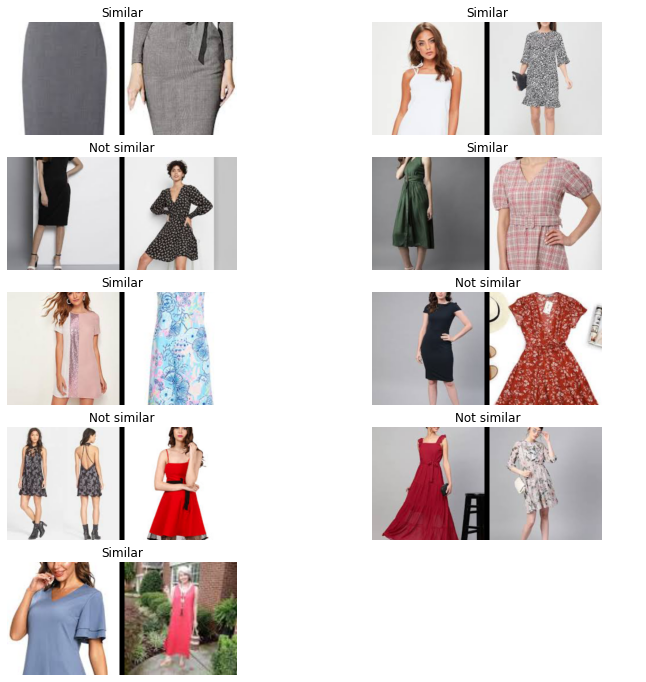

In [ ]:
dls.show_batch()


In [ ]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [ ]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

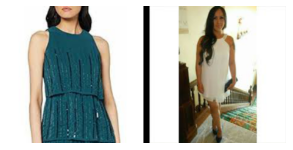

In [ ]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [ ]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)


In [ ]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [ ]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [ ]:
splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]


In [ ]:
def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

In [ ]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same

In [ ]:
def get_tuples(files): return [[f, *draw_other(f)] for f in files]


In [ ]:
def get_x(t): return t[:2]
def get_y(t): return t[2]
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = siamese.dataloaders(files)


In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

In [ ]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

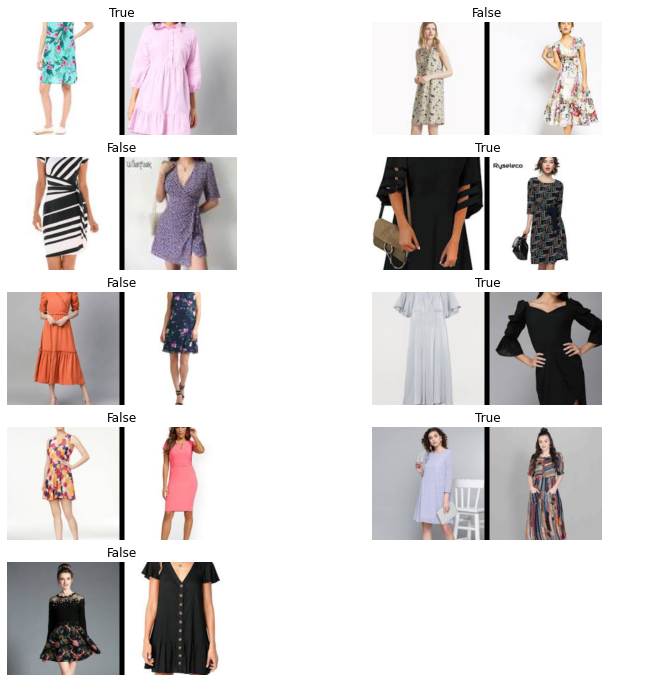

In [ ]:
dls.show_batch()


In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [ ]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [ ]:
encoder = create_body(resnet34, cut=-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [ ]:
head


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)


In [ ]:
learn.freeze()


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.2908675418875646e-06)

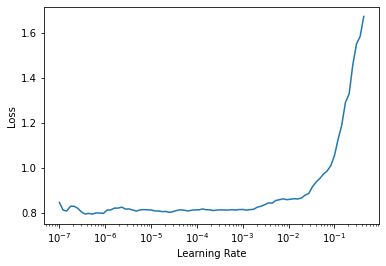

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(1, 5e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.858763,0.806196,0.524721,32:10


In [ ]:
learn.fit_one_cycle(4, 5e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.857312,0.784933,0.524721,03:43
1,0.858839,0.771784,0.532695,00:25
2,0.829957,0.732302,0.539075,00:25
3,0.798366,0.720314,0.540670,00:25


In [ ]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.775554,0.816866,0.500797,00:26
1,0.769428,0.749990,0.524721,00:26
2,0.753732,0.700476,0.523126,00:25
3,0.732875,0.695088,0.518341,00:25


In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.710699,0.689199,0.513557,00:25
1,0.704780,0.694596,0.505582,00:26
2,0.703195,0.690763,0.515152,00:25
3,0.707854,0.690031,0.507177,00:25


In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(3,3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.703832,0.690396,0.535885,00:33
1,0.695231,0.679892,0.570973,00:33
2,0.693460,0.676779,0.555024,00:32


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.678335,0.656785,0.609250,00:33
1,0.674988,0.647907,0.601276,00:32
2,0.659482,0.643606,0.606061,00:32


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3,5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.512333,0.681431,0.622010,00:33
1,0.518493,0.687348,0.629984,00:33
2,0.508496,0.679625,0.623604,00:32


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(6,5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.505282,0.700200,0.631579,00:32
1,0.520347,0.710954,0.620415,00:32
2,0.505588,0.679922,0.625199,00:32
3,0.490452,0.705576,0.623604,00:32
4,0.479595,0.685608,0.628389,00:32
5,0.475220,0.684492,0.633174,00:32


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3,3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.573833,0.649728,0.629984,00:33
1,0.570096,0.650740,0.634769,00:33
2,0.559382,0.649803,0.623604,00:32


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, slice(3e-5,1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.554742,0.685439,0.622010,00:33
1,0.543637,0.700370,0.615630,00:33
2,0.541574,0.682204,0.618820,00:32
3,0.528457,0.680617,0.618820,00:33


In [ ]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

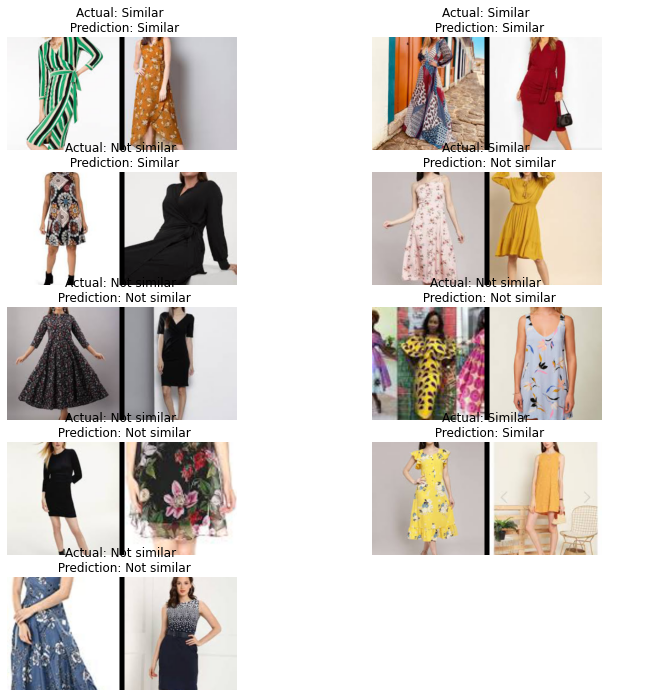

In [ ]:
learn.show_results()


In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

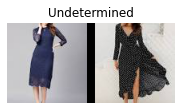

In [ ]:
imgtest = PILImage.create(files[561])
imgval = PILImage.create(files[1000])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

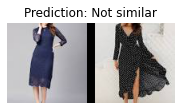

In [ ]:
res = learn.siampredict(siamtest)
